In [32]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [33]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [34]:
! nvidia-smi

Sun Jun 12 23:51:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 27%   35C    P8    22W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# MongoDB

In [35]:
from pymongo import MongoClient
import pymongo

In [36]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2015 = db.rm_patent_cn_2015
    db_rm_us_2015 = db.rm_patent_us_2015
    db_rm_de_2015 = db.rm_patent_de_2015

    
except errors.ConnectionFailure as err:
    print(err)

# 2015

## Company數量

In [37]:
data_assignee = db_rm_de_2015.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [38]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [39]:
data_assignee = db_rm_cn_2015.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [40]:
data_assignee = db_rm_us_2015.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [41]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [42]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
57,Samsung Electronics Co Ltd,346
25,Intel Corp,261
63,Telefonaktiebolaget LM Ericsson AB,86
49,Qualcomm Inc,83
8,Chengdu Qinchuan IoT Technology Co Ltd,82
56,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,81
31,Jiangsu IoT Research and Development Center,61
10,Cisco Technology Inc,50
1,Afero Inc,48
28,International Business Machines Corp,46


In [43]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [44]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,346,5.846439
1,Intel Corp,261,5.564520
2,Telefonaktiebolaget LM Ericsson AB,86,4.454347
3,Qualcomm Inc,83,4.418841
4,Chengdu Qinchuan IoT Technology Co Ltd,82,4.406719
5,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,81,4.394449
6,Jiangsu IoT Research and Development Center,61,4.110874
7,Cisco Technology Inc,50,3.912023
8,Afero Inc,48,3.871201
9,International Business Machines Corp,46,3.828641


In [45]:
com_ls = list(com_df.company)

## Data

In [46]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2015.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2015.csv")

In [47]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AT,AU,BR,CA,CH,CL,CN,...,PT,RU,SA,SG,SI,TN,TW,US,UY,ZA
30,Afero Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,0.0,0.0
51,Apple Inc,0.0,0.0,0.0,2.0,10.0,1.0,0.0,0.0,46.0,...,0.0,1.0,0.0,0.0,0.0,0.0,17.0,57.0,0.0,0.0
152,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
186,Cisco Technology Inc,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0
191,Convida Wireless LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [48]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [49]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AP,AR,AT,AU,BR,CA,CH,CL,CN,CO,...,PT,RU,SA,SG,SI,TN,TW,US,UY,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.0,0.000000,0.0,0.008920,0.000000,0.001982,0.0,0.0,0.157582,0.0,...,0.0,0.000991,0.0,0.000000,0.0,0.0,0.012884,0.349851,0.0,0.000000
Intel Corp,0.0,0.000000,0.0,0.000000,0.018950,0.001458,0.0,0.0,0.177843,0.0,...,0.0,0.002915,0.0,0.004373,0.0,0.0,0.058309,0.427114,0.0,0.000000
Telefonaktiebolaget LM Ericsson AB,0.0,0.015326,0.0,0.007663,0.019157,0.011494,0.0,0.0,0.137931,0.0,...,0.0,0.011494,0.0,0.000000,0.0,0.0,0.011494,0.340996,0.0,0.015326
Qualcomm Inc,0.0,0.000000,0.0,0.009404,0.040752,0.006270,0.0,0.0,0.178683,0.0,...,0.0,0.000000,0.0,0.003135,0.0,0.0,0.050157,0.272727,0.0,0.000000
Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.964706,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.011765,0.0,0.000000


In [50]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [51]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [52]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [53]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [54]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

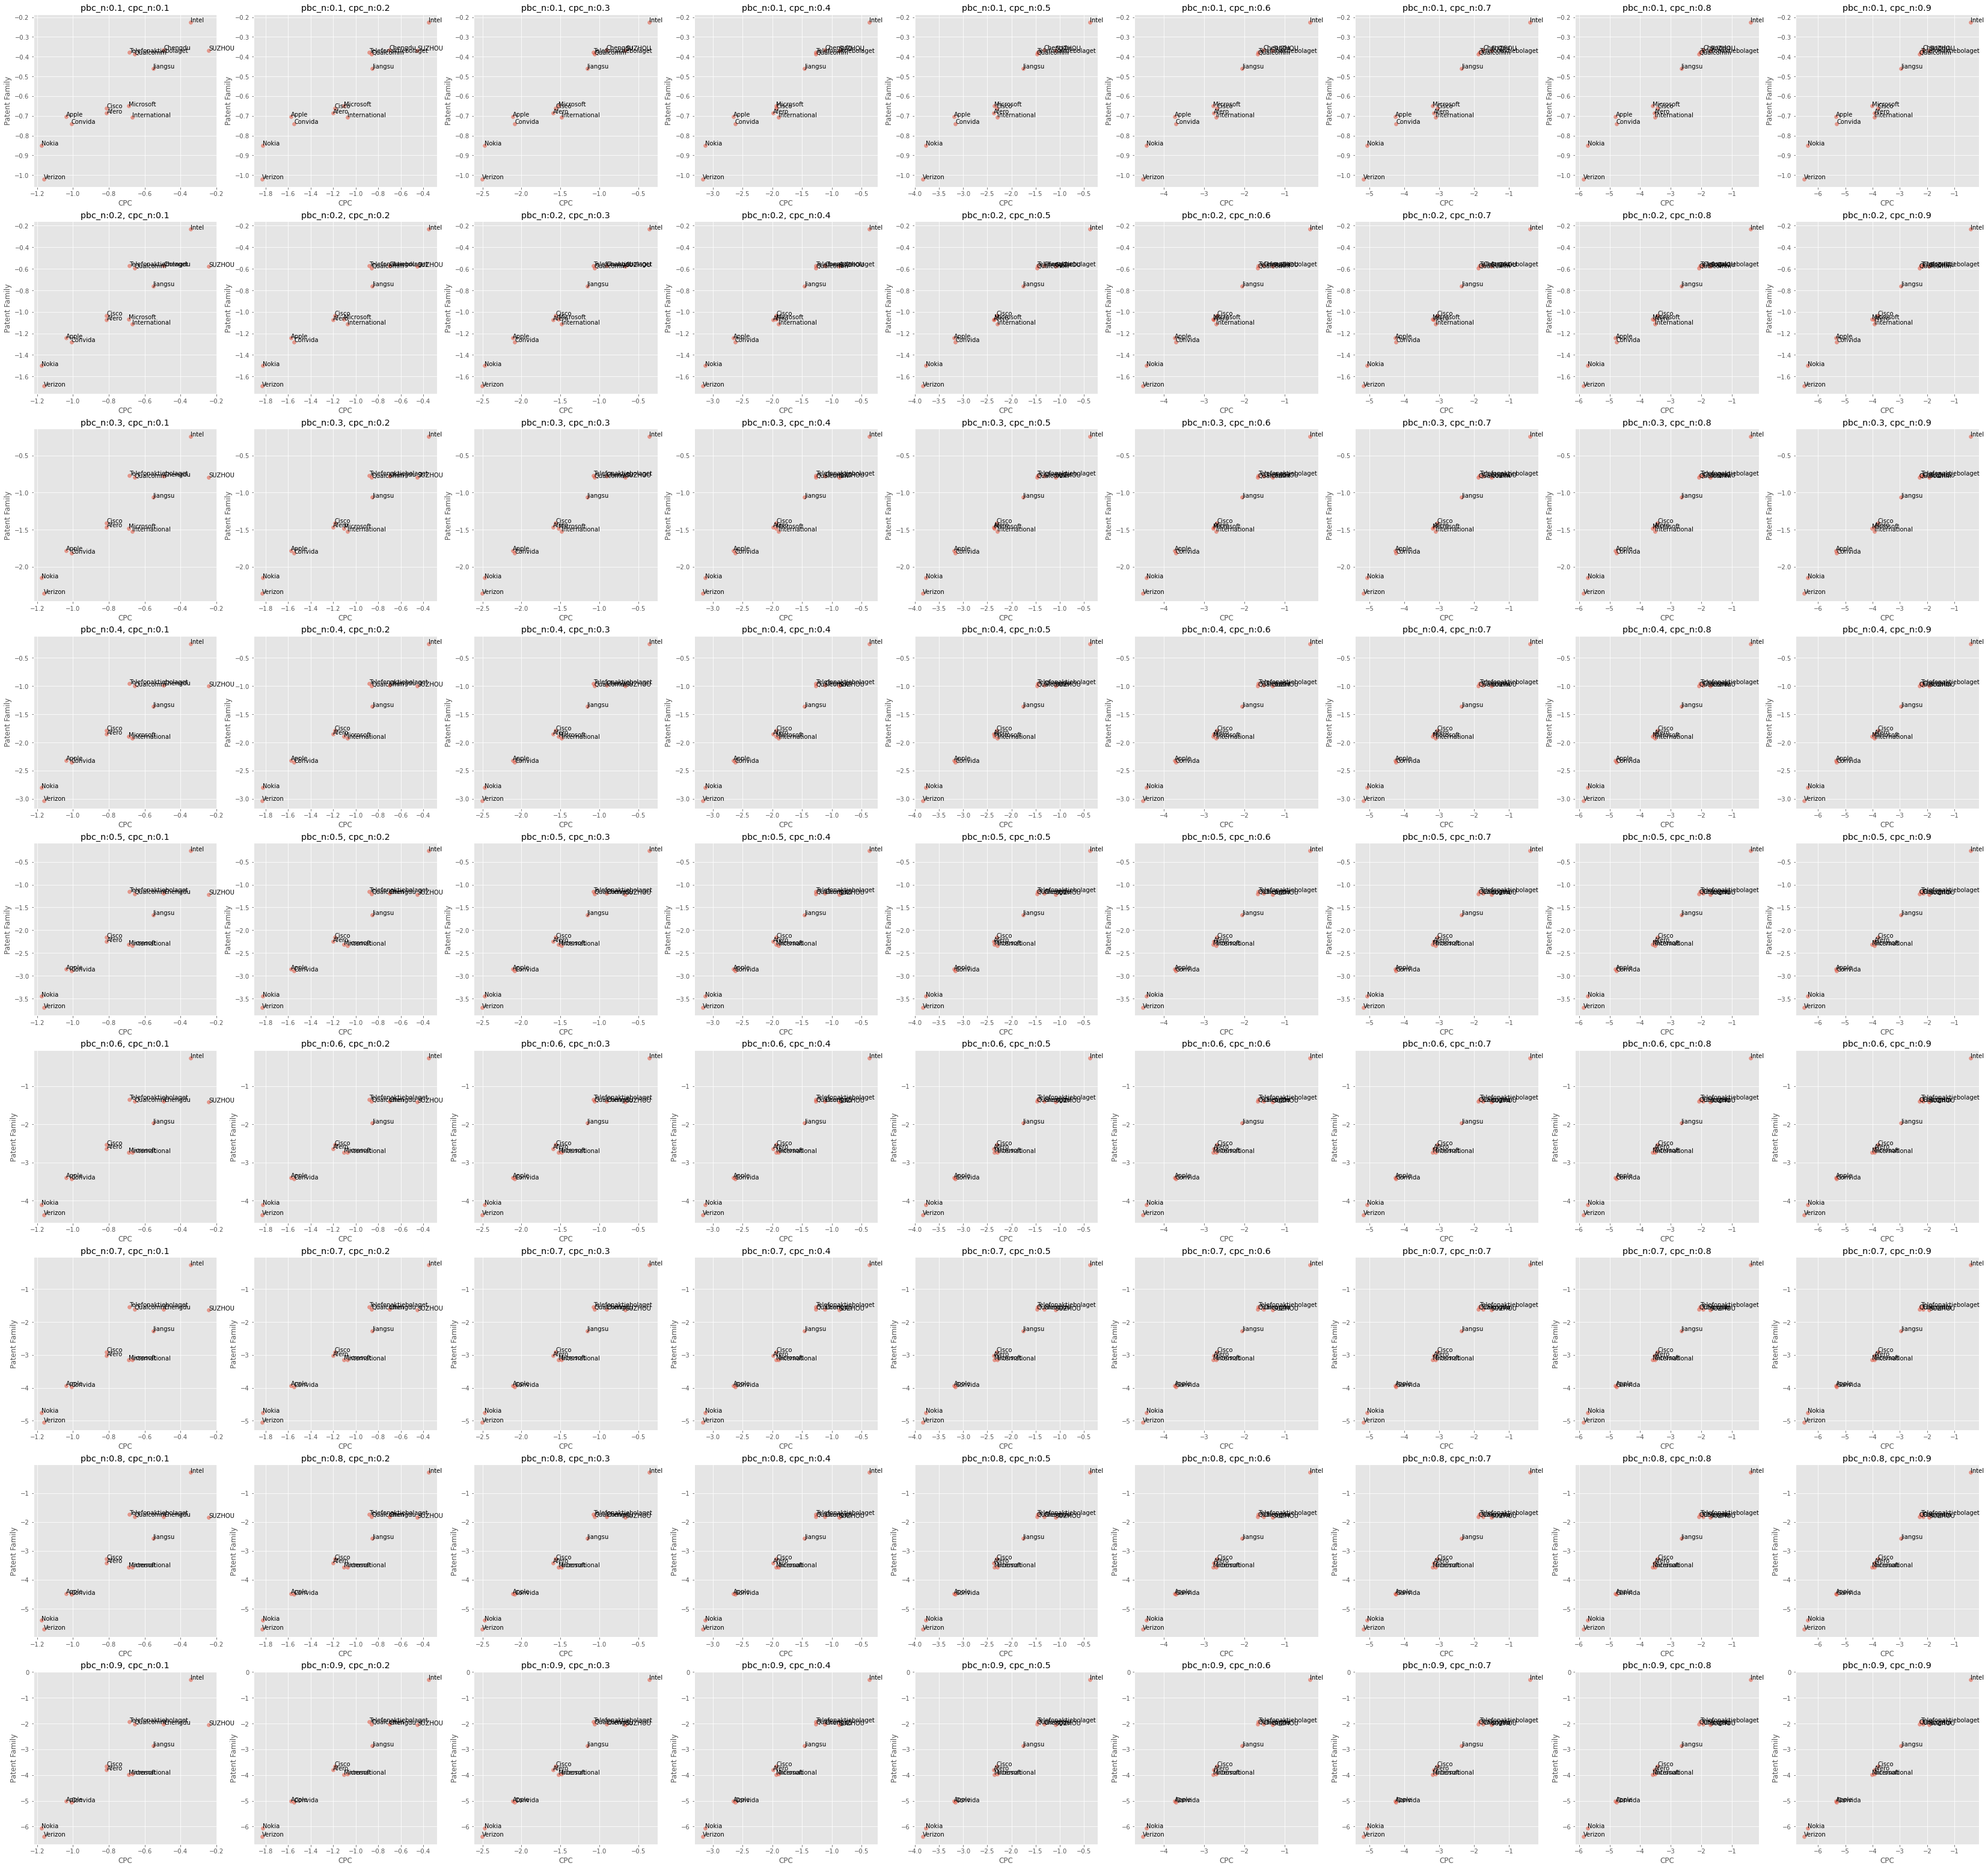

In [55]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2015_1.png'.format(pbc_n))

In [56]:
c_df

,cpc,country
company,,
Intel Corp,0.407276,0.288479
Telefonaktiebolaget LM Ericsson AB,2.237107,1.929330
Qualcomm Inc,2.286774,2.017924
Chengdu Qinchuan IoT Technology Co Ltd,2.152099,2.023468
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,1.930384,2.055028
Jiangsu IoT Research and Development Center,2.962911,2.868549
Cisco Technology Inc,3.805826,3.653624
Afero Inc,3.933216,3.806974
International Business Machines Corp,3.926096,3.963853


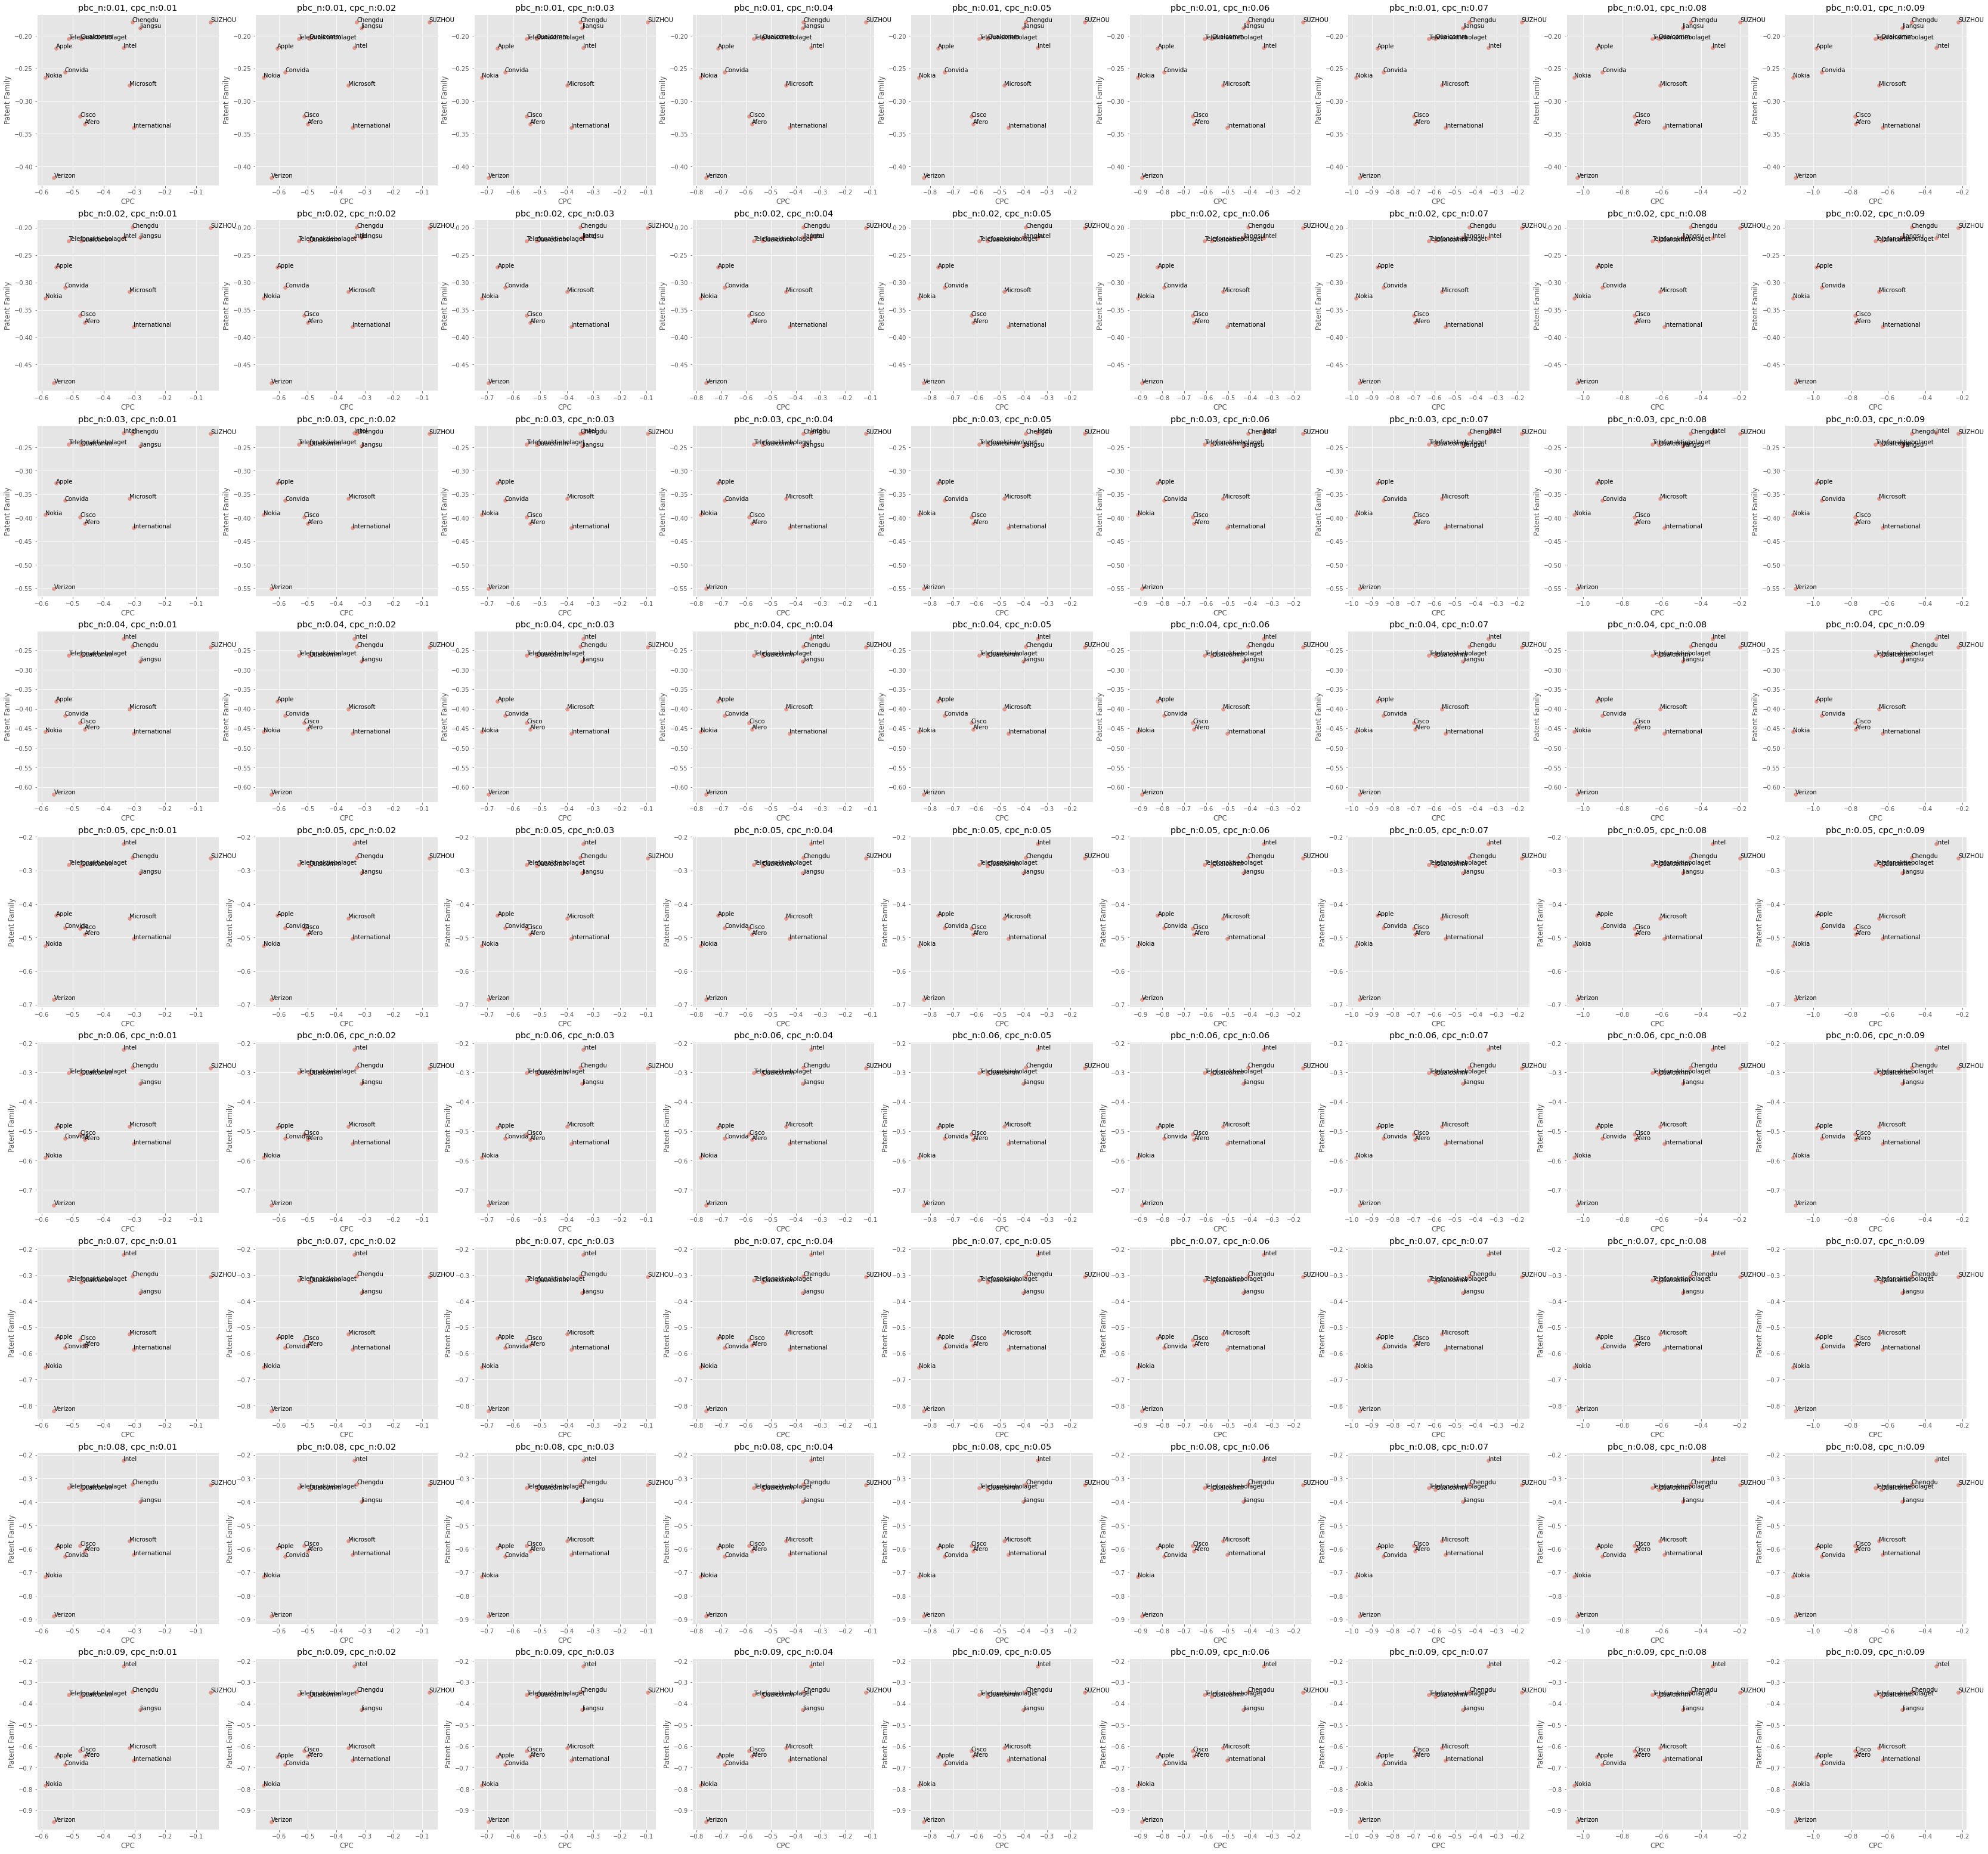

In [57]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2015_2.png'.format(pbc_n))

In [58]:
c_df

,cpc,country
company,,
Intel Corp,0.342899,0.224101
Telefonaktiebolaget LM Ericsson AB,0.667392,0.359616
Qualcomm Inc,0.635964,0.367115
Chengdu Qinchuan IoT Technology Co Ltd,0.473137,0.344506
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.222682,0.347326
Jiangsu IoT Research and Development Center,0.523041,0.428678
Cisco Technology Inc,0.774835,0.622633
Afero Inc,0.772949,0.646707
International Business Machines Corp,0.628175,0.665933


In [65]:
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)

,company,cpc,country
0,Intel Corp,0.342899,0.224101
1,Telefonaktiebolaget LM Ericsson AB,0.667392,0.359616
2,Qualcomm Inc,0.635964,0.367115
3,Chengdu Qinchuan IoT Technology Co Ltd,0.473137,0.344506
4,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.222682,0.347326
5,Jiangsu IoT Research and Development Center,0.523041,0.428678
6,Cisco Technology Inc,0.774835,0.622633
7,Afero Inc,0.772949,0.646707
8,International Business Machines Corp,0.628175,0.665933
9,Microsoft Technology Licensing LLC,0.648944,0.608475


In [69]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

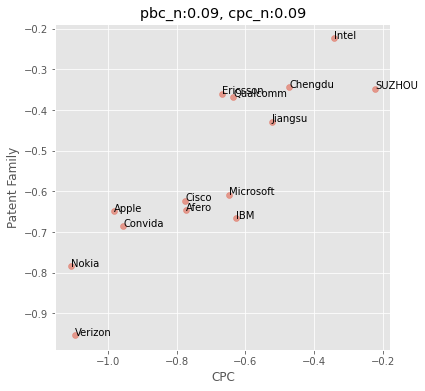

In [70]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [60]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [61]:
competitor_ls

[1, 2, 1, 1, 1, 1, 4, 4, 3, 3, 4, 4, 4, 4]

In [62]:
c_df

,cpc,country
company,,
Intel Corp,0.342899,0.224101
Telefonaktiebolaget LM Ericsson AB,0.667392,0.359616
Qualcomm Inc,0.635964,0.367115
Chengdu Qinchuan IoT Technology Co Ltd,0.473137,0.344506
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.222682,0.347326
Jiangsu IoT Research and Development Center,0.523041,0.428678
Cisco Technology Inc,0.774835,0.622633
Afero Inc,0.772949,0.646707
International Business Machines Corp,0.628175,0.665933
